In [4]:
import pandas as pd
from pathlib import Path
import json
import numpy as np
import geopandas as gpd
import folium
import branca.colormap as cm
import libpysal
import matplotlib.pyplot as plt
from shapely.geometry import shape, Point

from libpysal.weights import Queen, Rook, KNN
import splot
from esda.moran import Moran
from splot.esda import moran_scatterplot
import geopandas as gpd
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"

In [5]:
ROOT = Path.cwd().parent.parent
RAW = ROOT / 'data' / 'raw'
PROCESSED = ROOT / 'data' / 'processed'
OUT = ROOT / 'out'
ANALYSIS = ROOT / 'data' / 'analysis'

In [13]:
gdf = gpd.read_file(OUT / 'reg_results2.geojson')
gdf.head()
gdf_plot = gdf[['geometry', 'cluster_name_km_2', 'exp_schools_glm', 'residual_glm', 'primary', 'population']]



In [7]:
order_km2 = ["Urban 1", "Urban 2", "Urban 3", "Urban 4", "Urban 5","Urban 6", "Rural 1", "Rural 2", "Rural 3", "Rural 4"]
palette_km2 = gdf[['cluster_name_km_2', 'cluster_color_km_2']].drop_duplicates().set_index('cluster_name_km_2').to_dict()['cluster_color_km_2']
palette_km2 = {k: palette_km2[k] for k in order_km2}

In [12]:
vmin, vmax, vcenter = gdf.residual_glm.min(), gdf.residual_glm.max(), 0
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap = 'RdBu'
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

# gdf_plot.explore(column='residual_glm', legend=True, tiles='cartodbpositron', cmap=cmap)


In [9]:
vmin, vmax, vcenter

(-17.706936874988997, 5.836620013286525, 0)

# Plot residuals relative to place type

Text(-1.375, 52.99, 'Ilkeston')

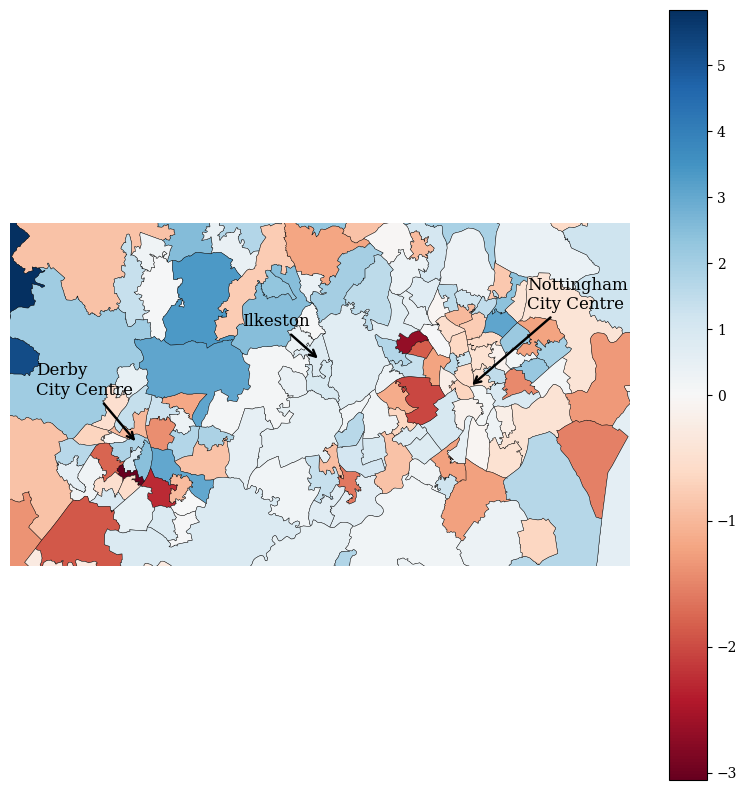

In [10]:
notts_ylim = (52.85, 53.05)
notts_xlim = (-1.6, -1)

# get dataframe which is only within notts_ylim and notts_xlim
gdf_notts = gdf.cx[notts_xlim[0]:notts_xlim[1], notts_ylim[0]:notts_ylim[1]]

vmin, vmax, vcenter = gdf_notts.residual_glm.min(), gdf_notts.residual_glm.max(), 0
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap = 'RdBu'
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

fs = 10
ncols=5
fig, ax = plt.subplots(1, figsize=(10, 10))
gdf_notts.plot(
    # legend=True,
    column='residual_glm',
    ax=ax,
    # palette=palette_km,
    # categorical=True,
    legend=True,
    edgecolor='black',
    linewidth=0.3,
    cmap=cmap,
    norm=norm,
)
ax.set_axis_off()
ax.set_ylim(*notts_ylim)
ax.set_xlim(*notts_xlim)
arrowprops = dict(facecolor='black',  arrowstyle='->', linewidth=1.75)
ilkeston = (-1.30, 52.97)
ax.annotate("Nottingham\nCity Centre", style='normal', xy=(-1.1549, 52.9545), fontsize=12, color='black', xytext=(-1.1, 53), arrowprops=arrowprops)
ax.annotate("Derby\nCity Centre", xy=(-1.4769, 52.9216), fontsize=12, color='black', arrowprops=arrowprops, xytext=(-1.575, 52.95))
ax.annotate("Ilkeston", xy=ilkeston, fontsize=12, color='black', arrowprops=arrowprops, xytext=(-1.375, 52.99))

/Users/toby/anaconda3/envs/connectivity-analysis/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


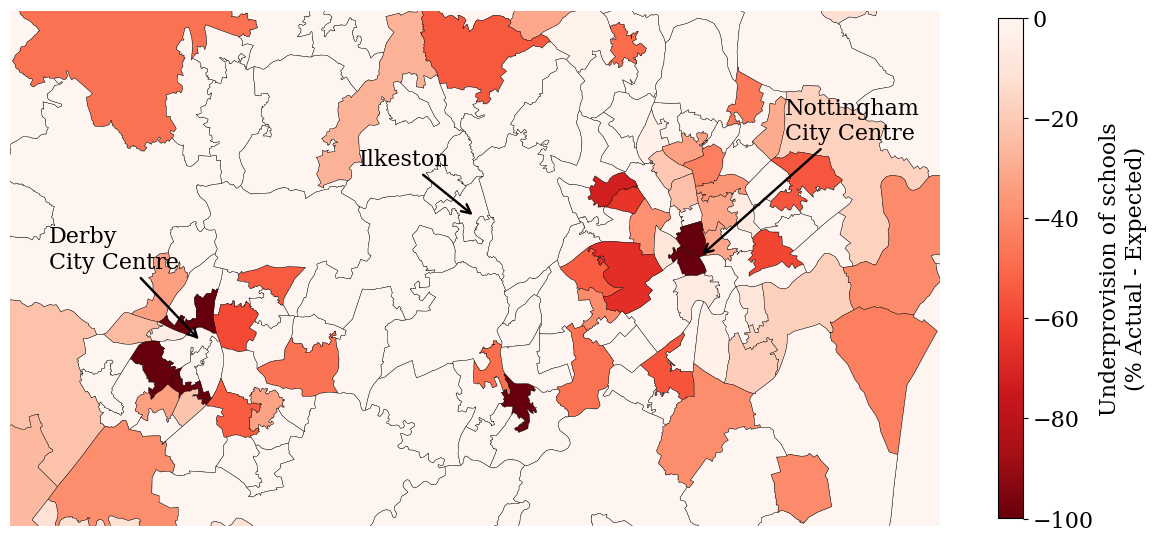

In [14]:
# Plot it with only identifying under-provisioned areas

notts_ylim = (52.85, 53.05)
notts_xlim = (-1.6, -1)

import matplotlib
# fig, ax = plt.subplots(figsize=(15, 20))
font = {
    # 'family' : 'normal',
    # 'weight' : 'bold',
    'size'   : 16
}
matplotlib.rc('font', **font)

# get dataframe which is only within notts_ylim and notts_xlim
gdf_notts = gdf.cx[notts_xlim[0]:notts_xlim[1], notts_ylim[0]:notts_ylim[1]]
gdf_notts['proportion_expected_glm'] = ((gdf_notts['primary']) / gdf_notts['exp_schools_glm'] * 100) -100

vmin, vmax, vcenter = gdf_notts.residual_glm.min(), gdf_notts.residual_glm.max(), 0
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap = 'RdBu'
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

fs = 10
ncols=5
fig, ax = plt.subplots(1, figsize=(15, 10))
gdf_notts.plot(
    # legend=True,
    column='proportion_expected_glm',
    ax=ax,
    # palette=palette_km,
    # categorical=True,
    legend=True,
    edgecolor='black',
    linewidth=0.3,
    vmin=gdf_notts.proportion_expected_glm.min(),
    vmax=0,
    cmap="Reds_r",
    # cmap=cmap,
    # norm=norm,
    legend_kwds={
        "shrink":.65,
        "label": "Underprovision of schools\n(% Actual - Expected)",
    },
    # legend_kwds={'loc': 'lower right'}
)
ax.set_axis_off()
ax.set_ylim(*notts_ylim)
ax.set_xlim(*notts_xlim)
arrowprops = dict(facecolor='black',  arrowstyle='->', linewidth=1.75)
ilkeston = (-1.30, 52.97)
ax.annotate("Nottingham\nCity Centre", style='normal', xy=(-1.1549, 52.9545),  color='black', xytext=(-1.1, 53), arrowprops=arrowprops)
ax.annotate("Derby\nCity Centre", xy=(-1.4769, 52.9216),  color='black', arrowprops=arrowprops, xytext=(-1.575, 52.95))
ax.annotate("Ilkeston", xy=ilkeston,  color='black', arrowprops=arrowprops, xytext=(-1.375, 52.99))
fig.savefig(OUT / 'underprovision.png', dpi=300, bbox_inches='tight')

/Users/toby/anaconda3/envs/connectivity-analysis/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Text(-1.375, 52.99, 'Ilkeston')

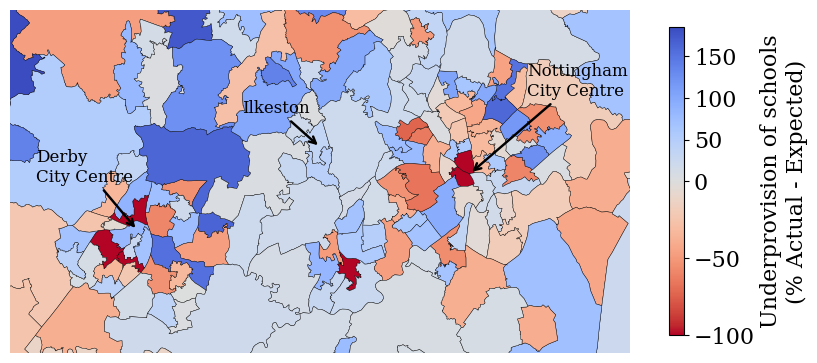

In [15]:
# Plot it with only identifying under-provisioned areas

notts_ylim = (52.85, 53.05)
notts_xlim = (-1.6, -1)

# get dataframe which is only within notts_ylim and notts_xlim
gdf_notts = gdf.cx[notts_xlim[0]:notts_xlim[1], notts_ylim[0]:notts_ylim[1]]
gdf_notts['proportion_expected_glm'] = ((gdf_notts['primary']) / gdf_notts['exp_schools_glm'] * 100) -100

vmin, vmax, vcenter = gdf_notts.proportion_expected_glm.min(), gdf_notts.proportion_expected_glm.max(), 0
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap = 'RdBu'
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

fs = 10
ncols=5
fig, ax = plt.subplots(1, figsize=(10, 10))
gdf_notts.plot(
    # legend=True,
    column='proportion_expected_glm',
    ax=ax,
    # palette=palette_km,
    # categorical=True,
    legend=True,
    edgecolor='black',
    linewidth=0.3,
    vmin=gdf_notts.proportion_expected_glm.min(),
    # vmax=0,
    cmap="coolwarm_r",
    # vcenter=0,
    # cmap=cmap,
    norm=norm,
    legend_kwds={
        "shrink":.4,
        "label": "Underprovision of schools\n(% Actual - Expected)",
    },
    # legend_kwds={'loc': 'lower right'}
)
ax.set_axis_off()
ax.set_ylim(*notts_ylim)
ax.set_xlim(*notts_xlim)
arrowprops = dict(facecolor='black',  arrowstyle='->', linewidth=1.75)
ilkeston = (-1.30, 52.97)
ax.annotate("Nottingham\nCity Centre", style='normal', xy=(-1.1549, 52.9545), fontsize=12, color='black', xytext=(-1.1, 53), arrowprops=arrowprops)
ax.annotate("Derby\nCity Centre", xy=(-1.4769, 52.9216), fontsize=12, color='black', arrowprops=arrowprops, xytext=(-1.575, 52.95))
ax.annotate("Ilkeston", xy=ilkeston, fontsize=12, color='black', arrowprops=arrowprops, xytext=(-1.375, 52.99))

In [16]:

gdf_notts.proportion_expected_glm.describe()

count    155.000000
mean      18.246470
std       61.837380
min     -100.000000
25%      -30.378346
50%       13.579676
75%       60.663605
max      184.505815
Name: proportion_expected_glm, dtype: float64

In [17]:
gdf_plot['proportion_expected_glm'] = ((gdf_plot['primary']) / gdf_plot['exp_schools_glm'] * 100) -100
# gdf_plot.explore(column='proportion_expected_glm', legend=True, tiles='cartodbpositron', cmap='Reds_r', vmax=0)

/Users/toby/anaconda3/envs/connectivity-analysis/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
